# Portfolio Optimization

This notebook demonstrates:
- Mean-variance portfolio optimization
- Efficient frontier construction
- Constraint handling (position limits, sector constraints)
- Risk parity and other allocation strategies
- Portfolio performance analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dervflow import PortfolioOptimizer, RiskParityOptimizer
import seaborn as sns

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
np.random.seed(42)

def calculate_risk_contributions(weights: np.ndarray, covariance: np.ndarray) -> np.ndarray:
    """Compute percentage risk contribution for each asset."""
    portfolio_variance = float(weights @ covariance @ weights)
    marginal_contrib = covariance @ weights
    contributions = weights * marginal_contrib / portfolio_variance
    return contributions


## 1. Generate Asset Return Data

Create synthetic historical returns for a portfolio of assets.

In [2]:
# Define assets
assets = ['Tech', 'Finance', 'Healthcare', 'Energy', 'Consumer', 'Utilities']
n_assets = len(assets)
n_periods = 252 * 5  # Five years of daily returns

# Generate correlated returns
mean_returns = np.array([0.12, 0.10, 0.11, 0.08, 0.09, 0.07]) / 252  # Daily returns
volatilities = np.array([0.25, 0.20, 0.22, 0.28, 0.18, 0.15]) / np.sqrt(252)  # Daily vol

# Create correlation matrix
correlation = np.array([
    [1.00, 0.60, 0.50, 0.40, 0.55, 0.30],
    [0.60, 1.00, 0.45, 0.35, 0.50, 0.40],
    [0.50, 0.45, 1.00, 0.30, 0.40, 0.35],
    [0.40, 0.35, 0.30, 1.00, 0.35, 0.25],
    [0.55, 0.50, 0.40, 0.35, 1.00, 0.45],
    [0.30, 0.40, 0.35, 0.25, 0.45, 1.00]
])

# Covariance matrix
cov_matrix = np.outer(volatilities, volatilities) * correlation

# Generate returns
returns = np.random.multivariate_normal(mean_returns, cov_matrix, n_periods)
returns_df = pd.DataFrame(returns, columns=assets)

print("Asset Statistics (Annualized):")
print(f"{'Asset':<12} {'Return':<10} {'Volatility':<12} {'Sharpe':<10}")
print("-" * 50)
for asset in assets:
    ret = returns_df[asset].mean() * 252
    vol = returns_df[asset].std() * np.sqrt(252)
    sharpe = ret / vol
    print(f"{asset:<12} {ret*100:>6.2f}%    {vol*100:>6.2f}%      {sharpe:>6.3f}")
expected_returns = returns_df.mean().values * 252
covariance_matrix = returns_df.cov().values * 252


Asset Statistics (Annualized):
Asset        Return     Volatility   Sharpe    
--------------------------------------------------
Tech          10.83%     25.24%       0.429
Finance       12.24%     20.03%       0.611
Healthcare     6.92%     21.25%       0.326
Energy        13.64%     27.88%       0.489
Consumer       3.07%     17.83%       0.172
Utilities     -7.69%     15.11%      -0.509


### Visualize Correlation Matrix

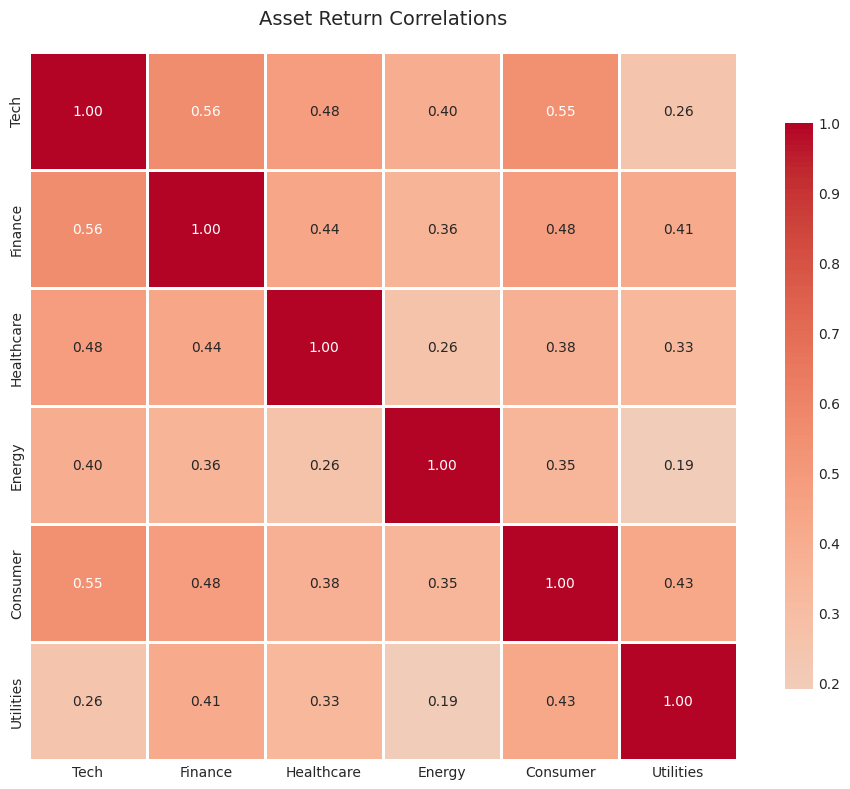

In [3]:
# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(returns_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
           center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Asset Return Correlations', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

## 2. Mean-Variance Optimization

Find the optimal portfolio weights using mean-variance optimization.

In [4]:
# Initialize optimizer
optimizer = PortfolioOptimizer(
    expected_returns.astype(np.float64),
    covariance_matrix.astype(np.float64)
)

# Optimize for maximum Sharpe ratio (annual risk-free rate)
long_only = np.zeros(n_assets, dtype=np.float64)
max_sharpe = optimizer.optimize(
    risk_free_rate=0.03,
    min_weights=long_only
)

print("Maximum Sharpe Ratio Portfolio:")
print(f"Expected Return: {max_sharpe['expected_return']*100:.2f}%")
print(f"Volatility: {max_sharpe['volatility']*100:.2f}%")
print(f"Sharpe Ratio: {max_sharpe['sharpe_ratio']:.3f}")
print("\nWeights:")
for asset, weight in zip(assets, max_sharpe['weights']):
    print(f"  {asset:<12} {weight*100:>6.2f}%")


Maximum Sharpe Ratio Portfolio:
Expected Return: 12.85%
Volatility: 19.34%
Sharpe Ratio: 0.510

Weights:
  Tech          -0.00%
  Finance       56.11%
  Healthcare    -0.00%
  Energy        43.89%
  Consumer      -0.00%
  Utilities     -0.00%


### Minimum Variance Portfolio

In [5]:
# Optimize for minimum variance
rf_rate = 0.03
min_var = optimizer.optimize(min_weights=long_only)

print("Minimum Variance Portfolio:")
print(f"Expected Return: {min_var['expected_return']*100:.2f}%")
print(f"Volatility: {min_var['volatility']*100:.2f}%")
sharpe_display = min_var['sharpe_ratio'] if min_var['sharpe_ratio'] is not None else float('nan')
rf_rate = 0.03
sharpe_display = (min_var['expected_return'] - rf_rate) / min_var['volatility'] if min_var['volatility'] > 0 else float('nan')
print(f"Sharpe Ratio: {sharpe_display:.3f}")
print("\nWeights:")
for asset, weight in zip(assets, min_var['weights']):
    print(f"  {asset:<12} {weight*100:>6.2f}%")


Minimum Variance Portfolio:
Expected Return: -0.37%
Volatility: 13.03%
Sharpe Ratio: -0.259

Weights:
  Tech           0.00%
  Finance        8.07%
  Healthcare    13.15%
  Energy         7.33%
  Consumer      20.68%
  Utilities     50.77%


### Visualize Portfolio Allocations

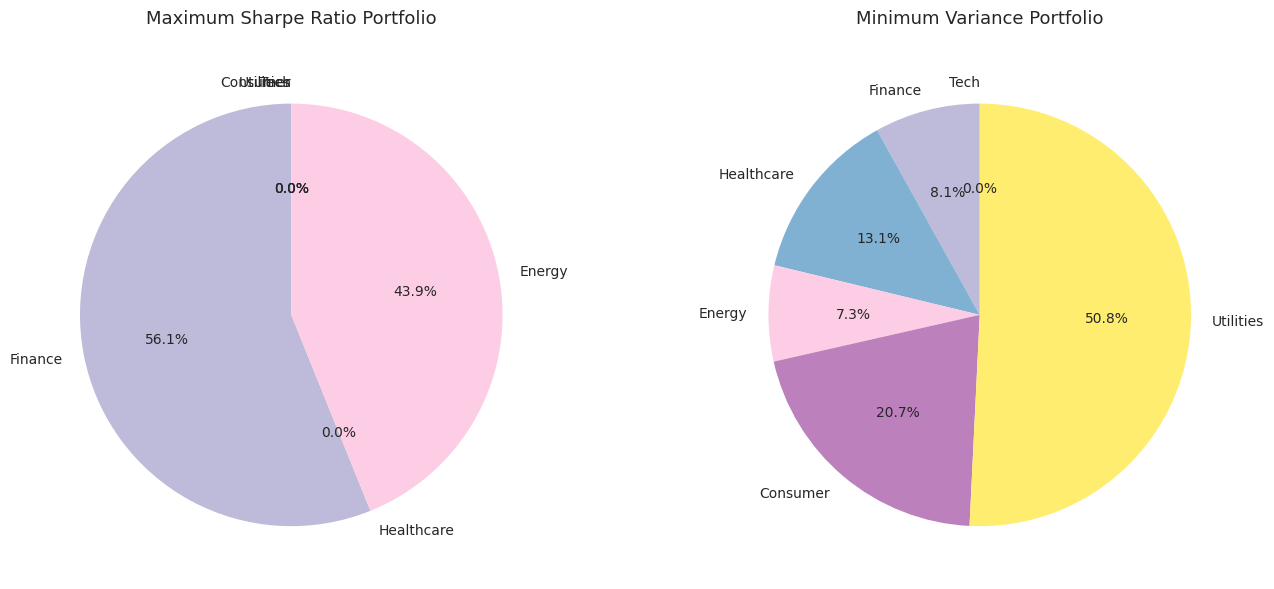

In [6]:
# Compare allocations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Max Sharpe
colors = plt.cm.Set3(np.linspace(0, 1, n_assets))
max_sharpe_plot = np.clip(max_sharpe['weights'], 0, None)
max_sharpe_plot = max_sharpe_plot / max_sharpe_plot.sum()
wedges1, texts1, autotexts1 = ax1.pie(max_sharpe_plot, labels=assets, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
ax1.set_title('Maximum Sharpe Ratio Portfolio', fontsize=13, pad=20)

# Min Variance
min_var_plot = np.clip(min_var['weights'], 0, None)
min_var_plot = min_var_plot / min_var_plot.sum()
wedges2, texts2, autotexts2 = ax2.pie(min_var_plot, labels=assets, autopct='%1.1f%%',
                                       colors=colors, startangle=90)
ax2.set_title('Minimum Variance Portfolio', fontsize=13, pad=20)

plt.tight_layout()
plt.show()

## 3. Efficient Frontier

Generate the efficient frontier showing the risk-return trade-off.

In [7]:
# Generate efficient frontier
frontier = optimizer.efficient_frontier(num_points=50, min_weights=long_only)

# Extract data
frontier_returns = np.array([p['expected_return'] for p in frontier])
frontier_vols = np.array([p['volatility'] for p in frontier])
frontier_sharpes = np.array([p['sharpe_ratio'] if p['sharpe_ratio'] is not None else np.nan for p in frontier])

print(f"Generated {len(frontier)} efficient portfolios")


Generated 50 efficient portfolios


### Plot Efficient Frontier

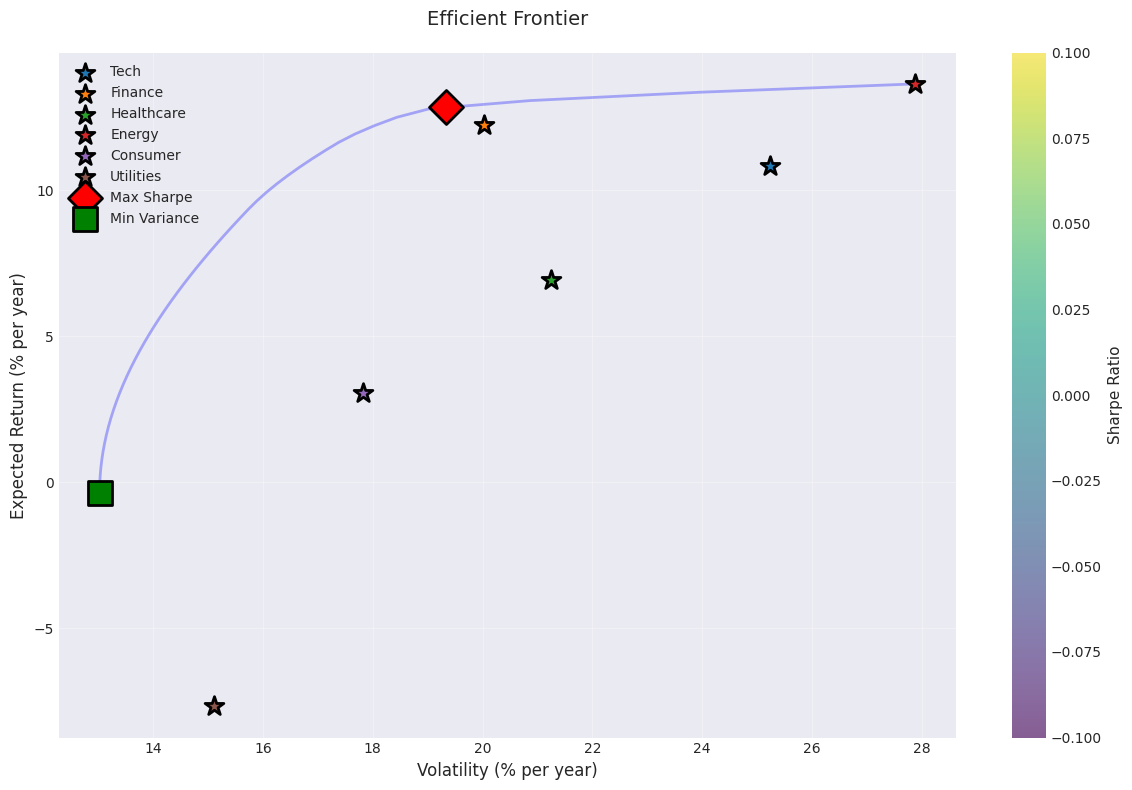

In [8]:
# Plot efficient frontier
fig, ax = plt.subplots(figsize=(12, 8))

# Efficient frontier
scatter = ax.scatter(frontier_vols * 100, frontier_returns * 100, 
                    c=frontier_sharpes, cmap='viridis', s=50, alpha=0.6, edgecolors='black')
ax.plot(frontier_vols * 100, frontier_returns * 100, 'b-', linewidth=2, alpha=0.3)

# Individual assets
for i, asset in enumerate(assets):
    ret = returns_df[asset].mean() * 252
    vol = returns_df[asset].std() * np.sqrt(252)
    ax.scatter(vol * 100, ret * 100, s=200, marker='*', 
              edgecolors='black', linewidths=2, label=asset, zorder=5)

# Special portfolios
ax.scatter(max_sharpe['volatility'] * 100, 
          max_sharpe['expected_return'] * 100,
          s=300, marker='D', color='red', edgecolors='black', linewidths=2,
          label='Max Sharpe', zorder=6)
ax.scatter(min_var['volatility'] * 100, 
          min_var['expected_return'] * 100,
          s=300, marker='s', color='green', edgecolors='black', linewidths=2,
          label='Min Variance', zorder=6)

# Formatting
ax.set_xlabel('Volatility (% per year)', fontsize=12)
ax.set_ylabel('Expected Return (% per year)', fontsize=12)
ax.set_title('Efficient Frontier', fontsize=14, pad=20)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Sharpe Ratio', fontsize=11)

plt.tight_layout()
plt.show()

## 4. Constrained Optimization

Apply various constraints to the optimization problem.

### Position Limits

In [9]:
# Optimize with position limits (max 30% per asset)
min_bounds = np.zeros(n_assets, dtype=np.float64)
max_bounds = np.full(n_assets, 0.30, dtype=np.float64)

constrained = optimizer.optimize(
    risk_free_rate=0.03,
    min_weights=min_bounds,
    max_weights=max_bounds
)

print("Constrained Portfolio (Max 30% per asset):")
print(f"Expected Return: {constrained['expected_return']*100:.2f}%")
print(f"Volatility: {constrained['volatility']*100:.2f}%")
print(f"Sharpe Ratio: {constrained['sharpe_ratio']:.3f}")
print("\nWeights:")
for asset, weight in zip(assets, constrained['weights']):
    print(f"  {asset:<12} {weight*100:>6.2f}%")

print(f"\nSharpe Ratio Reduction: {(max_sharpe['sharpe_ratio'] - constrained['sharpe_ratio']):.4f}")


Constrained Portfolio (Max 30% per asset):
Expected Return: 11.70%
Volatility: 18.46%
Sharpe Ratio: 0.472

Weights:
  Tech          30.00%
  Finance       30.00%
  Healthcare    10.00%
  Energy        30.00%
  Consumer       0.00%
  Utilities      0.00%

Sharpe Ratio Reduction: 0.0380


### Sector Constraints

In [10]:
# Define sector groups with desired limits
sectors = {
    'Growth': ['Tech', 'Healthcare'],      # Max 50% combined
    'Value': ['Finance', 'Energy'],        # Max 40% combined
    'Defensive': ['Consumer', 'Utilities'] # Min 20% combined
}

sector_min = np.zeros(n_assets, dtype=np.float64)
sector_max = np.ones(n_assets, dtype=np.float64)

for asset in sectors['Growth']:
    sector_max[assets.index(asset)] = 0.25
for asset in sectors['Value']:
    sector_max[assets.index(asset)] = 0.20
for asset in sectors['Defensive']:
    sector_min[assets.index(asset)] = 0.10

sector_constrained = optimizer.optimize(
    risk_free_rate=0.03,
    min_weights=sector_min,
    max_weights=sector_max,
)

print("Sector-Constrained Portfolio:")
print(f"Expected Return: {sector_constrained['expected_return']*100:.2f}%")
print(f"Volatility: {sector_constrained['volatility']*100:.2f}%")
print(f"Sharpe Ratio: {sector_constrained['sharpe_ratio']:.3f}")
print("\nWeights by Sector:")
for sector, asset_list in sectors.items():
    sector_weight = sum(sector_constrained['weights'][assets.index(a)] for a in asset_list)
    print(f"  {sector:<12} {sector_weight*100:>6.2f}%")
    for asset in asset_list:
        weight = sector_constrained['weights'][assets.index(asset)]
        print(f"    {asset:<10} {weight*100:>6.2f}%")


Sector-Constrained Portfolio:
Expected Return: 8.46%
Volatility: 16.23%
Sharpe Ratio: 0.336

Weights by Sector:
  Growth        40.00%
    Tech        25.00%
    Healthcare  15.00%
  Value         40.00%
    Finance     20.00%
    Energy      20.00%
  Defensive     20.00%
    Consumer    10.00%
    Utilities   10.00%


### Compare Constrained Portfolios


Portfolio Comparison:
      Portfolio  Return (%)  Volatility (%)  Sharpe Ratio
  Unconstrained   12.854584       19.337222      0.509617
Position Limits   11.704195       18.456278      0.471612
  Sector Limits    8.459079       16.225292      0.336455


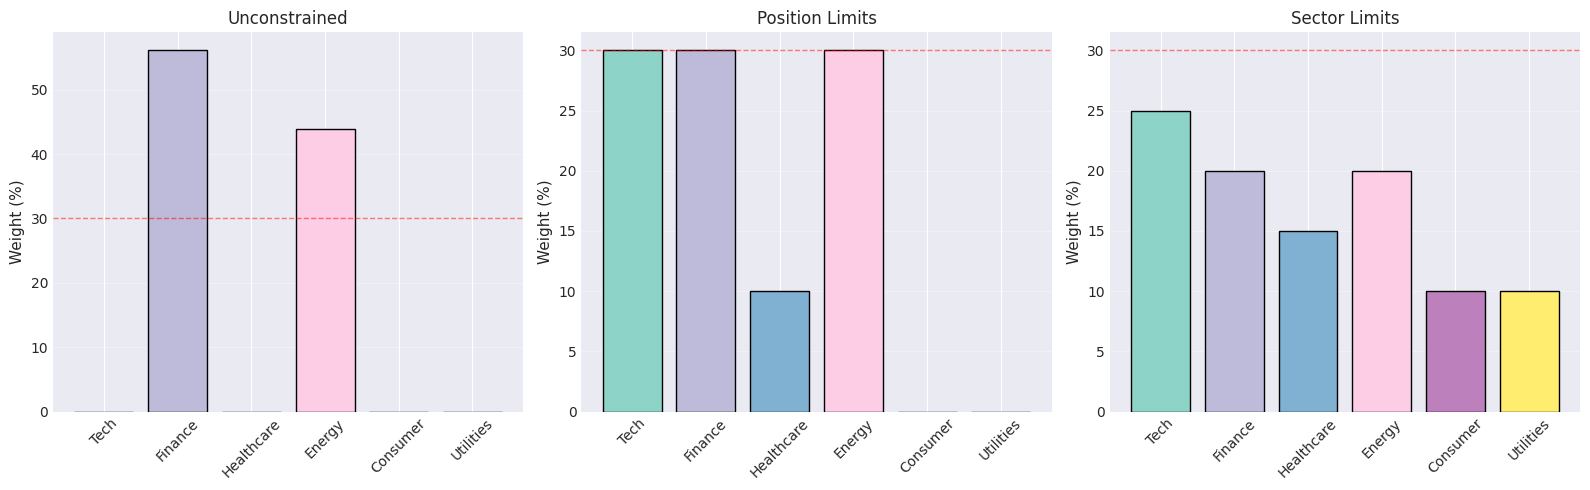

In [11]:
# Create comparison DataFrame
portfolios = {
    'Unconstrained': max_sharpe,
    'Position Limits': constrained,
    'Sector Limits': sector_constrained,
}

comparison = pd.DataFrame({
    'Portfolio': list(portfolios.keys()),
    'Return (%)': [p['expected_return']*100 for p in portfolios.values()],
    'Volatility (%)': [p['volatility']*100 for p in portfolios.values()],
    'Sharpe Ratio': [p['sharpe_ratio'] for p in portfolios.values()],
})

print("\nPortfolio Comparison:")
print(comparison.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, (name, portfolio) in enumerate(portfolios.items()):
    axes[idx].bar(assets, portfolio['weights'] * 100, color=colors, edgecolor='black')
    axes[idx].set_ylabel('Weight (%)', fontsize=11)
    axes[idx].set_title(name, fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].axhline(y=30, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()


## 5. Risk Parity Portfolio

Allocate capital such that each asset contributes equally to portfolio risk.

In [12]:
# Risk parity optimization
rp_optimizer = RiskParityOptimizer(covariance_matrix.astype(np.float64))
risk_parity_weights = rp_optimizer.optimize()
risk_parity_contrib = rp_optimizer.risk_contributions(risk_parity_weights)

risk_parity_return = float(risk_parity_weights @ expected_returns)
risk_parity_vol = float(np.sqrt(risk_parity_weights @ covariance_matrix @ risk_parity_weights))
risk_parity_sharpe = (risk_parity_return - 0.03) / risk_parity_vol

risk_parity = {
    'weights': risk_parity_weights,
    'expected_return': risk_parity_return,
    'volatility': risk_parity_vol,
    'sharpe_ratio': risk_parity_sharpe,
    'risk_contributions': risk_parity_contrib,
}

print("Risk Parity Portfolio:")
print(f"Expected Return: {risk_parity_return*100:.2f}%")
print(f"Volatility: {risk_parity_vol*100:.2f}%")
print(f"Sharpe Ratio: {risk_parity_sharpe:.3f}")
print("\nWeights and Risk Contributions:")
for asset, weight, risk_contrib in zip(assets, risk_parity_weights, risk_parity_contrib):
    print(f"  {asset:<12} Weight: {weight*100:>6.2f}%  Risk Contrib: {risk_contrib*100:>6.2f}%")


Risk Parity Portfolio:
Expected Return: 4.87%
Volatility: 14.16%
Sharpe Ratio: 0.132

Weights and Risk Contributions:
  Tech         Weight:  12.39%  Risk Contrib:  16.67%
  Finance      Weight:  15.54%  Risk Contrib:  16.67%
  Healthcare   Weight:  16.18%  Risk Contrib:  16.67%
  Energy       Weight:  13.58%  Risk Contrib:  16.67%
  Consumer     Weight:  17.75%  Risk Contrib:  16.67%
  Utilities    Weight:  24.57%  Risk Contrib:  16.67%


### Visualize Risk Contributions

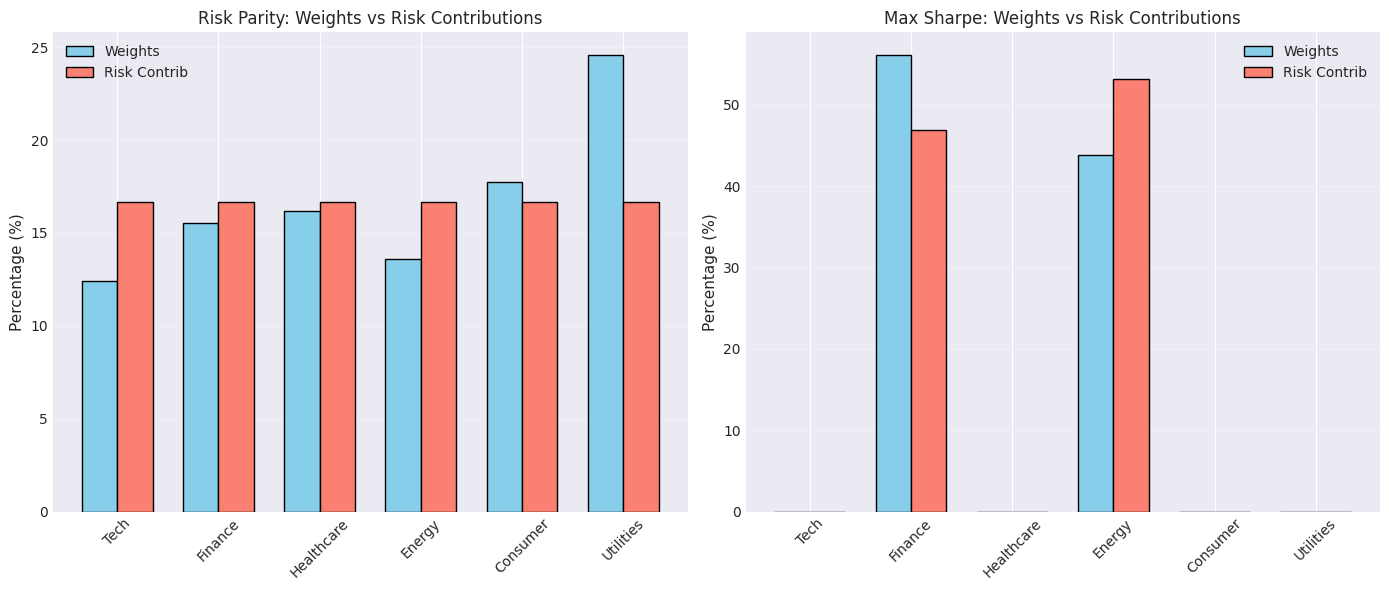

In [13]:
# Compare weights vs risk contributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(assets))
width = 0.35

# Risk Parity
ax1.bar(x - width/2, risk_parity['weights'] * 100, width, label='Weights', color='skyblue', edgecolor='black')
ax1.bar(x + width/2, risk_parity['risk_contributions'] * 100, width, label='Risk Contrib', color='salmon', edgecolor='black')
ax1.set_ylabel('Percentage (%)', fontsize=11)
ax1.set_title('Risk Parity: Weights vs Risk Contributions', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(assets, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Max Sharpe for comparison
max_sharpe_risk_contrib = calculate_risk_contributions(max_sharpe['weights'], covariance_matrix)
ax2.bar(x - width/2, max_sharpe['weights'] * 100, width, label='Weights', color='skyblue', edgecolor='black')
ax2.bar(x + width/2, max_sharpe_risk_contrib * 100, width, label='Risk Contrib', color='salmon', edgecolor='black')
ax2.set_ylabel('Percentage (%)', fontsize=11)
ax2.set_title('Max Sharpe: Weights vs Risk Contributions', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(assets, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## 6. Target Return/Risk Optimization

Optimize for specific return or risk targets.

In [14]:
# Target portfolio from efficient frontier near 10% return
desired_return = 0.10

target_portfolio = min(frontier, key=lambda p: abs(p['expected_return'] - desired_return))
actual_return = target_portfolio['expected_return']
actual_vol = target_portfolio['volatility']
rf_rate = 0.03
if target_portfolio['sharpe_ratio'] is not None:
    sharpe_display = target_portfolio['sharpe_ratio']
else:
    sharpe_display = (actual_return - rf_rate) / actual_vol if actual_vol > 0 else float('nan')

print(f"Frontier Portfolio Closest to {desired_return*100:.1f}% Return:")
print(f"Expected Return: {actual_return*100:.2f}%")
print(f"Volatility: {actual_vol*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_display:.3f}")
print("\nWeights:")
for asset, weight in zip(assets, target_portfolio['weights']):
    print(f"  {asset:<12} {weight*100:>6.2f}%")


Frontier Portfolio Closest to 10.0% Return:
Expected Return: 9.92%
Volatility: 16.06%
Sharpe Ratio: 0.431

Weights:
  Tech          -0.00%
  Finance       44.27%
  Healthcare    20.58%
  Energy        18.94%
  Consumer      16.21%
  Utilities      0.00%
